In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

In [9]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [10]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"

data = ScreenedData(r_max=10)

data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../dataset/EthanT3/", postfix = "EthanT3", target=target)
data.include(data_path = "../../dataset/EthanT4/",  postfix = "EthanT4", target=target)
data.include(data_path = "../../dataset/EthanT5/",  postfix = "EthanT5", target=target)
data.include(data_path = "../../dataset/EthanT6/",  postfix = "EthanT6", target=target)

data.include(data_path = "../../dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../dataset/EthenT3/", postfix = "EthenT3", target=target)
data.include(data_path = "../../dataset/EthenT4/",  postfix = "EthenT4", target=target)
data.include(data_path = "../../dataset/EthenT5/",  postfix = "EthenT5", target=target)
data.include(data_path = "../../dataset/EthenT6/",  postfix = "EthenT6", target=target)


data.include(data_path = "../../dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

# SetUp descriptor And Normalisation

In [11]:
import pickle

model_path = "../../models/Descriptor"
target = "P"

descriptor_C = pickle.load(open(model_path + "C/" + target + "/descriptor.dump", "rb"))
descriptor_H = pickle.load(open(model_path + "H/" + target + "/descriptor.dump", "rb"))

descriptors = {
    "C": descriptor_C,
    "H": descriptor_H
}

In [12]:
descriptor_H

In [13]:
normalisations = {
    "C": np.load(model_path + "C/" + target + "/normalisation.npy"),
    "H": np.load(model_path + "H/" + target + "/normalisation.npy")
}

# Fetch Networks 

In [14]:
path = model_path

name_C = model_path + "C/" + target + "/C_" + target + ".h5"
name_H = model_path + "H/" + target + "/H_" + target + ".h5"


model_C = keras.models.load_model(name_C)
model_H = keras.models.load_model(name_H)

networks = {
    "C": model_C,
    "H": model_H
}

# Guess Method 

In [15]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu, AbstractDataset
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from pyscf.scf import hf
from SCFInitialGuess.utilities.dataset import density_from_fock, fock_from_density

def init_guess_by_ann(mol):
    
    mole = mol.get_pyscf_molecule()
    
    p  = hf.init_guess_by_wolfsberg_helmholtz(mole).copy() # TODO set up my own GWH in SCFInitialGuess
    
    for atom_index, atom in enumerate(mol.species):
        
        mask = mol.make_atom_mask(atom_index)
        
        
        G = descriptors[atom].calculate_atom_descriptor(
            atom_index, 
            mol,
            descriptors[atom].number_of_descriptors
        )
        
        G_norm = AbstractDataset.normalize(G, *normalisations[atom])
        
        #f(G)
        f = networks[atom].predict(G.reshape(1, -1))
        
        f_batch = reconstruct_from_triu(
            f,
            N_BASIS[mol.basis][atom]
        )
        
        p[mask] = f_batch.flatten()
        
    h = hf.get_hcore(mole)
    s = hf.get_ovlp(mole)
        
    # add iteration
    p = density_from_fock(fock_from_density(p, s, h, mole), s, mole)
        
    return p
        
    

# Analysis 

## Utils 

In [16]:
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    #train=(s_train, p_train),
    train=(data.S[0], data.T[0]),
    validation=(data.S[1], data.T[1]),
    test=(data.S[2], data.T[2]),
    mu=0,
    std=1
)

 ## Execution 

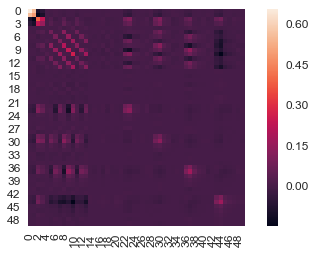

In [20]:
sns.heatmap(init_guess_by_ann(data.molecules[2][0]), square=True)

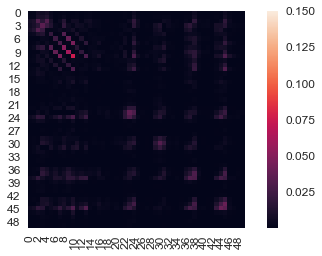

In [18]:
sns.heatmap(
    np.abs(
        init_guess_by_ann(
            data.molecules[2][0]
        ) - data.T[2][0]
    ), square=True, vmax=0.15)

In [11]:
p_nn = np.array([
    init_guess_by_ann(mol) for mol in data.molecules[2]
])

In [12]:
np.save("data/p_nn.npy", p_nn)

In [13]:
p_nn = np.load("data/p_nn.npy")

# Scatter 

In [14]:
plt.rc("figure", figsize=(6,5))

In [15]:
def flatten(x):
    y = []
    for xi in x:
        y += list(xi.flatten())
    return y

p_exp = flatten(data.T[2])
p_nn_flatten = flatten(p_nn)

In [16]:
ind = np.arange(len(p_exp))
np.random.shuffle(ind)
print(len(p_exp), len(p_nn_flatten))

10259432 10259432


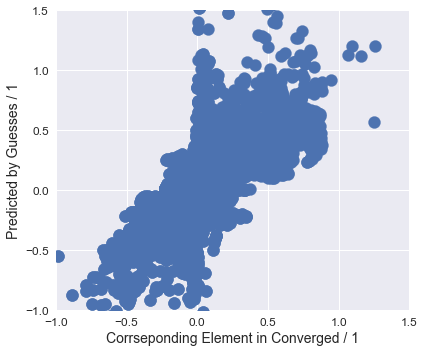

In [17]:
n_max = len(p_exp)
plt.scatter(
    np.array(p_exp),#[ind[:n_max]], 
    np.array(p_nn_flatten),#[ind[:n_max]]
)

plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)

plt.xlabel("Corrseponding Element in Converged / 1")
plt.ylabel("Predicted by Guesses / 1")

plt.tight_layout()

plt.show()

# Properties 

In [18]:
from SCFInitialGuess.utilities.analysis import analyze_raw_batch, format_raw

from SCFInitialGuess.utilities.analysis import analyze_raw_batch
result = analyze_raw_batch(
    p_nn,
    data.T[2],
    data.S[2],
    data.molecules[2]
)

[ ] 2019-02-10 00:42:33: 1 / 2225
[ ] 2019-02-10 00:42:33: 2 / 2225
[ ] 2019-02-10 00:42:34: 3 / 2225
[ ] 2019-02-10 00:42:35: 4 / 2225
[ ] 2019-02-10 00:42:35: 5 / 2225
[ ] 2019-02-10 00:42:36: 6 / 2225
[ ] 2019-02-10 00:42:36: 7 / 2225
[ ] 2019-02-10 00:42:37: 8 / 2225
[ ] 2019-02-10 00:42:37: 9 / 2225
[ ] 2019-02-10 00:42:38: 10 / 2225
[ ] 2019-02-10 00:42:38: 11 / 2225
[ ] 2019-02-10 00:42:39: 12 / 2225
[ ] 2019-02-10 00:42:39: 13 / 2225
[ ] 2019-02-10 00:42:40: 14 / 2225
[ ] 2019-02-10 00:42:40: 15 / 2225
[ ] 2019-02-10 00:42:41: 16 / 2225
[ ] 2019-02-10 00:42:41: 17 / 2225
[ ] 2019-02-10 00:42:42: 18 / 2225
[ ] 2019-02-10 00:42:42: 19 / 2225
[ ] 2019-02-10 00:42:43: 20 / 2225
[ ] 2019-02-10 00:42:43: 21 / 2225
[ ] 2019-02-10 00:42:44: 22 / 2225
[ ] 2019-02-10 00:42:44: 23 / 2225
[ ] 2019-02-10 00:42:45: 24 / 2225
[ ] 2019-02-10 00:42:45: 25 / 2225
[ ] 2019-02-10 00:42:46: 26 / 2225
[ ] 2019-02-10 00:42:46: 27 / 2225
[ ] 2019-02-10 00:42:47: 28 / 2225
[ ] 2019-02-10 00:42:47: 29 /

[ ] 2019-02-10 00:44:40: 232 / 2225
[ ] 2019-02-10 00:44:40: 233 / 2225
[ ] 2019-02-10 00:44:41: 234 / 2225
[ ] 2019-02-10 00:44:41: 235 / 2225
[ ] 2019-02-10 00:44:42: 236 / 2225
[ ] 2019-02-10 00:44:42: 237 / 2225
[ ] 2019-02-10 00:44:43: 238 / 2225
[ ] 2019-02-10 00:44:43: 239 / 2225
[ ] 2019-02-10 00:44:44: 240 / 2225
[ ] 2019-02-10 00:44:44: 241 / 2225
[ ] 2019-02-10 00:44:45: 242 / 2225
[ ] 2019-02-10 00:44:45: 243 / 2225
[ ] 2019-02-10 00:44:46: 244 / 2225
[ ] 2019-02-10 00:44:47: 245 / 2225
[ ] 2019-02-10 00:44:47: 246 / 2225
[ ] 2019-02-10 00:44:48: 247 / 2225
[ ] 2019-02-10 00:44:48: 248 / 2225
[ ] 2019-02-10 00:44:49: 249 / 2225
[ ] 2019-02-10 00:44:49: 250 / 2225
[ ] 2019-02-10 00:44:50: 251 / 2225
[ ] 2019-02-10 00:44:50: 252 / 2225
[ ] 2019-02-10 00:44:51: 253 / 2225
[ ] 2019-02-10 00:44:51: 254 / 2225
[ ] 2019-02-10 00:44:52: 255 / 2225
[ ] 2019-02-10 00:44:52: 256 / 2225
[ ] 2019-02-10 00:44:53: 257 / 2225
[ ] 2019-02-10 00:44:53: 258 / 2225
[ ] 2019-02-10 00:44:54: 259

[ ] 2019-02-10 00:46:45: 460 / 2225
[ ] 2019-02-10 00:46:46: 461 / 2225
[ ] 2019-02-10 00:46:46: 462 / 2225
[ ] 2019-02-10 00:46:47: 463 / 2225
[ ] 2019-02-10 00:46:47: 464 / 2225
[ ] 2019-02-10 00:46:48: 465 / 2225
[ ] 2019-02-10 00:46:48: 466 / 2225
[ ] 2019-02-10 00:46:49: 467 / 2225
[ ] 2019-02-10 00:46:50: 468 / 2225
[ ] 2019-02-10 00:46:50: 469 / 2225
[ ] 2019-02-10 00:46:51: 470 / 2225
[ ] 2019-02-10 00:46:51: 471 / 2225
[ ] 2019-02-10 00:46:52: 472 / 2225
[ ] 2019-02-10 00:46:52: 473 / 2225
[ ] 2019-02-10 00:46:53: 474 / 2225
[ ] 2019-02-10 00:46:53: 475 / 2225
[ ] 2019-02-10 00:46:54: 476 / 2225
[ ] 2019-02-10 00:46:54: 477 / 2225
[ ] 2019-02-10 00:46:55: 478 / 2225
[ ] 2019-02-10 00:46:55: 479 / 2225
[ ] 2019-02-10 00:46:56: 480 / 2225
[ ] 2019-02-10 00:46:56: 481 / 2225
[ ] 2019-02-10 00:46:57: 482 / 2225
[ ] 2019-02-10 00:46:57: 483 / 2225
[ ] 2019-02-10 00:46:58: 484 / 2225
[ ] 2019-02-10 00:46:58: 485 / 2225
[ ] 2019-02-10 00:46:59: 486 / 2225
[ ] 2019-02-10 00:47:00: 487

[ ] 2019-02-10 00:50:21: 688 / 2225
[ ] 2019-02-10 00:50:22: 689 / 2225
[ ] 2019-02-10 00:50:23: 690 / 2225
[ ] 2019-02-10 00:50:24: 691 / 2225
[ ] 2019-02-10 00:50:25: 692 / 2225
[ ] 2019-02-10 00:50:26: 693 / 2225
[ ] 2019-02-10 00:50:27: 694 / 2225
[ ] 2019-02-10 00:50:29: 695 / 2225
[ ] 2019-02-10 00:50:30: 696 / 2225
[ ] 2019-02-10 00:50:32: 697 / 2225
[ ] 2019-02-10 00:50:34: 698 / 2225
[ ] 2019-02-10 00:50:38: 699 / 2225
[ ] 2019-02-10 00:50:41: 700 / 2225
[ ] 2019-02-10 00:50:43: 701 / 2225
[ ] 2019-02-10 00:50:44: 702 / 2225
[ ] 2019-02-10 00:50:46: 703 / 2225
[ ] 2019-02-10 00:50:47: 704 / 2225
[ ] 2019-02-10 00:50:48: 705 / 2225
[ ] 2019-02-10 00:50:49: 706 / 2225
[ ] 2019-02-10 00:50:50: 707 / 2225
[ ] 2019-02-10 00:50:51: 708 / 2225
[ ] 2019-02-10 00:50:52: 709 / 2225
[ ] 2019-02-10 00:50:53: 710 / 2225
[ ] 2019-02-10 00:50:54: 711 / 2225
[ ] 2019-02-10 00:50:54: 712 / 2225
[ ] 2019-02-10 00:50:55: 713 / 2225
[ ] 2019-02-10 00:50:56: 714 / 2225
[ ] 2019-02-10 00:50:57: 715

[ ] 2019-02-10 00:53:33: 916 / 2225
[ ] 2019-02-10 00:53:34: 917 / 2225
[ ] 2019-02-10 00:53:35: 918 / 2225
[ ] 2019-02-10 00:53:36: 919 / 2225
[ ] 2019-02-10 00:53:36: 920 / 2225
[ ] 2019-02-10 00:53:37: 921 / 2225
[ ] 2019-02-10 00:53:38: 922 / 2225
[ ] 2019-02-10 00:53:39: 923 / 2225
[ ] 2019-02-10 00:53:40: 924 / 2225
[ ] 2019-02-10 00:53:41: 925 / 2225
[ ] 2019-02-10 00:53:42: 926 / 2225
[ ] 2019-02-10 00:53:43: 927 / 2225
[ ] 2019-02-10 00:53:43: 928 / 2225
[ ] 2019-02-10 00:53:44: 929 / 2225
[ ] 2019-02-10 00:53:45: 930 / 2225
[ ] 2019-02-10 00:53:46: 931 / 2225
[ ] 2019-02-10 00:53:47: 932 / 2225
[ ] 2019-02-10 00:53:48: 933 / 2225
[ ] 2019-02-10 00:53:48: 934 / 2225
[ ] 2019-02-10 00:53:49: 935 / 2225
[ ] 2019-02-10 00:53:50: 936 / 2225
[ ] 2019-02-10 00:53:51: 937 / 2225
[ ] 2019-02-10 00:53:52: 938 / 2225
[ ] 2019-02-10 00:53:53: 939 / 2225
[ ] 2019-02-10 00:53:54: 940 / 2225
[ ] 2019-02-10 00:53:54: 941 / 2225
[ ] 2019-02-10 00:53:55: 942 / 2225
[ ] 2019-02-10 00:53:56: 943

[ ] 2019-02-10 00:56:24: 1140 / 2225
[ ] 2019-02-10 00:56:24: 1141 / 2225
[ ] 2019-02-10 00:56:25: 1142 / 2225
[ ] 2019-02-10 00:56:26: 1143 / 2225
[ ] 2019-02-10 00:56:26: 1144 / 2225
[ ] 2019-02-10 00:56:27: 1145 / 2225
[ ] 2019-02-10 00:56:28: 1146 / 2225
[ ] 2019-02-10 00:56:29: 1147 / 2225
[ ] 2019-02-10 00:56:29: 1148 / 2225
[ ] 2019-02-10 00:56:30: 1149 / 2225
[ ] 2019-02-10 00:56:31: 1150 / 2225
[ ] 2019-02-10 00:56:31: 1151 / 2225
[ ] 2019-02-10 00:56:32: 1152 / 2225
[ ] 2019-02-10 00:56:33: 1153 / 2225
[ ] 2019-02-10 00:56:33: 1154 / 2225
[ ] 2019-02-10 00:56:34: 1155 / 2225
[ ] 2019-02-10 00:56:35: 1156 / 2225
[ ] 2019-02-10 00:56:35: 1157 / 2225
[ ] 2019-02-10 00:56:36: 1158 / 2225
[ ] 2019-02-10 00:56:37: 1159 / 2225
[ ] 2019-02-10 00:56:38: 1160 / 2225
[ ] 2019-02-10 00:56:38: 1161 / 2225
[ ] 2019-02-10 00:56:39: 1162 / 2225
[ ] 2019-02-10 00:56:40: 1163 / 2225
[ ] 2019-02-10 00:56:40: 1164 / 2225
[ ] 2019-02-10 00:56:41: 1165 / 2225
[ ] 2019-02-10 00:56:42: 1166 / 2225
[

[ ] 2019-02-10 00:58:53: 1362 / 2225
[ ] 2019-02-10 00:58:54: 1363 / 2225
[ ] 2019-02-10 00:58:54: 1364 / 2225
[ ] 2019-02-10 00:58:55: 1365 / 2225
[ ] 2019-02-10 00:58:55: 1366 / 2225
[ ] 2019-02-10 00:58:56: 1367 / 2225
[ ] 2019-02-10 00:58:57: 1368 / 2225
[ ] 2019-02-10 00:58:57: 1369 / 2225
[ ] 2019-02-10 00:58:58: 1370 / 2225
[ ] 2019-02-10 00:58:59: 1371 / 2225
[ ] 2019-02-10 00:58:59: 1372 / 2225
[ ] 2019-02-10 00:59:00: 1373 / 2225
[ ] 2019-02-10 00:59:00: 1374 / 2225
[ ] 2019-02-10 00:59:01: 1375 / 2225
[ ] 2019-02-10 00:59:01: 1376 / 2225
[ ] 2019-02-10 00:59:02: 1377 / 2225
[ ] 2019-02-10 00:59:03: 1378 / 2225
[ ] 2019-02-10 00:59:03: 1379 / 2225
[ ] 2019-02-10 00:59:04: 1380 / 2225
[ ] 2019-02-10 00:59:04: 1381 / 2225
[ ] 2019-02-10 00:59:05: 1382 / 2225
[ ] 2019-02-10 00:59:06: 1383 / 2225
[ ] 2019-02-10 00:59:06: 1384 / 2225
[ ] 2019-02-10 00:59:07: 1385 / 2225
[ ] 2019-02-10 00:59:08: 1386 / 2225
[ ] 2019-02-10 00:59:09: 1387 / 2225
[ ] 2019-02-10 00:59:10: 1388 / 2225
[

[ ] 2019-02-10 01:01:13: 1584 / 2225
[ ] 2019-02-10 01:01:13: 1585 / 2225
[ ] 2019-02-10 01:01:14: 1586 / 2225
[ ] 2019-02-10 01:01:15: 1587 / 2225
[ ] 2019-02-10 01:01:15: 1588 / 2225
[ ] 2019-02-10 01:01:16: 1589 / 2225
[ ] 2019-02-10 01:01:17: 1590 / 2225
[ ] 2019-02-10 01:01:17: 1591 / 2225
[ ] 2019-02-10 01:01:18: 1592 / 2225
[ ] 2019-02-10 01:01:19: 1593 / 2225
[ ] 2019-02-10 01:01:20: 1594 / 2225
[ ] 2019-02-10 01:01:20: 1595 / 2225
[ ] 2019-02-10 01:01:21: 1596 / 2225
[ ] 2019-02-10 01:01:22: 1597 / 2225
[ ] 2019-02-10 01:01:23: 1598 / 2225
[ ] 2019-02-10 01:01:24: 1599 / 2225
[ ] 2019-02-10 01:01:25: 1600 / 2225
[ ] 2019-02-10 01:01:25: 1601 / 2225
[ ] 2019-02-10 01:01:26: 1602 / 2225
[ ] 2019-02-10 01:01:27: 1603 / 2225
[ ] 2019-02-10 01:01:28: 1604 / 2225
[ ] 2019-02-10 01:01:28: 1605 / 2225
[ ] 2019-02-10 01:01:29: 1606 / 2225
[ ] 2019-02-10 01:01:30: 1607 / 2225
[ ] 2019-02-10 01:01:30: 1608 / 2225
[ ] 2019-02-10 01:01:31: 1609 / 2225
[ ] 2019-02-10 01:01:32: 1610 / 2225
[

[ ] 2019-02-10 01:03:36: 1806 / 2225
[ ] 2019-02-10 01:03:37: 1807 / 2225
[ ] 2019-02-10 01:03:38: 1808 / 2225
[ ] 2019-02-10 01:03:38: 1809 / 2225
[ ] 2019-02-10 01:03:39: 1810 / 2225
[ ] 2019-02-10 01:03:39: 1811 / 2225
[ ] 2019-02-10 01:03:40: 1812 / 2225
[ ] 2019-02-10 01:03:40: 1813 / 2225
[ ] 2019-02-10 01:03:41: 1814 / 2225
[ ] 2019-02-10 01:03:42: 1815 / 2225
[ ] 2019-02-10 01:03:42: 1816 / 2225
[ ] 2019-02-10 01:03:43: 1817 / 2225
[ ] 2019-02-10 01:03:43: 1818 / 2225
[ ] 2019-02-10 01:03:44: 1819 / 2225
[ ] 2019-02-10 01:03:44: 1820 / 2225
[ ] 2019-02-10 01:03:45: 1821 / 2225
[ ] 2019-02-10 01:03:45: 1822 / 2225
[ ] 2019-02-10 01:03:46: 1823 / 2225
[ ] 2019-02-10 01:03:46: 1824 / 2225
[ ] 2019-02-10 01:03:47: 1825 / 2225
[ ] 2019-02-10 01:03:48: 1826 / 2225
[ ] 2019-02-10 01:03:48: 1827 / 2225
[ ] 2019-02-10 01:03:49: 1828 / 2225
[ ] 2019-02-10 01:03:49: 1829 / 2225
[ ] 2019-02-10 01:03:50: 1830 / 2225
[ ] 2019-02-10 01:03:51: 1831 / 2225
[ ] 2019-02-10 01:03:51: 1832 / 2225
[

[ ] 2019-02-10 01:05:46: 2028 / 2225
[ ] 2019-02-10 01:05:46: 2029 / 2225
[ ] 2019-02-10 01:05:47: 2030 / 2225
[ ] 2019-02-10 01:05:47: 2031 / 2225
[ ] 2019-02-10 01:05:48: 2032 / 2225
[ ] 2019-02-10 01:05:48: 2033 / 2225
[ ] 2019-02-10 01:05:49: 2034 / 2225
[ ] 2019-02-10 01:05:49: 2035 / 2225
[ ] 2019-02-10 01:05:50: 2036 / 2225
[ ] 2019-02-10 01:05:50: 2037 / 2225
[ ] 2019-02-10 01:05:51: 2038 / 2225
[ ] 2019-02-10 01:05:52: 2039 / 2225
[ ] 2019-02-10 01:05:52: 2040 / 2225
[ ] 2019-02-10 01:05:53: 2041 / 2225
[ ] 2019-02-10 01:05:53: 2042 / 2225
[ ] 2019-02-10 01:05:54: 2043 / 2225
[ ] 2019-02-10 01:05:54: 2044 / 2225
[ ] 2019-02-10 01:05:55: 2045 / 2225
[ ] 2019-02-10 01:05:55: 2046 / 2225
[ ] 2019-02-10 01:05:56: 2047 / 2225
[ ] 2019-02-10 01:05:57: 2048 / 2225
[ ] 2019-02-10 01:05:57: 2049 / 2225
[ ] 2019-02-10 01:05:58: 2050 / 2225
[ ] 2019-02-10 01:05:58: 2051 / 2225
[ ] 2019-02-10 01:05:59: 2052 / 2225
[ ] 2019-02-10 01:05:59: 2053 / 2225
[ ] 2019-02-10 01:06:00: 2054 / 2225
[

In [19]:
print(format_raw(result))

AbsError: 4.55555E-03 +- 2.43692E-03
EhfError: 2.02017E-01 +- 4.44437E-01
IdemEror: 2.47429E-17 +- 7.98291E-18
OccError: 4.62571E-15 +- 3.84675E-15



## Pure 

In [20]:
from SCFInitialGuess.utilities.analysis import mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg
msg.print_level = 3

    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle


[ ] 2019-02-10 01:07:42: Iteration calculation: 0
[ ] 2019-02-10 01:07:42: Iteration calculation: 1
[ ] 2019-02-10 01:07:43: Iteration calculation: 2
[ ] 2019-02-10 01:07:43: Iteration calculation: 3
[ ] 2019-02-10 01:07:44: Iteration calculation: 4
[ ] 2019-02-10 01:07:44: Iteration calculation: 5
[ ] 2019-02-10 01:07:45: Iteration calculation: 6
[ ] 2019-02-10 01:07:45: Iteration calculation: 7
[ ] 2019-02-10 01:07:46: Iteration calculation: 8
[ ] 2019-02-10 01:07:46: Iteration calculation: 9
[ ] 2019-02-10 01:07:47: Iteration calculation: 10
[ ] 2019-02-10 01:07:47: Iteration calculation: 11
[ ] 2019-02-10 01:07:47: Iteration calculation: 12
[ ] 2019-02-10 01:07:48: Iteration calculation: 13
[ ] 2019-02-10 01:07:48: Iteration calculation: 14
[ ] 2019-02-10 01:07:49: Iteration calculation: 15
[ ] 2019-02-10 01:07:49: Iteration calculation: 16
[ ] 2019-02-10 01:07:49: Iteration calculation: 17
[ ] 2019-02-10 01:07:50: Iteration calculation: 18
[ ] 2019-02-10 01:07:50: Iteration calcul

[ ] 2019-02-10 01:08:40: Iteration calculation: 160
[ ] 2019-02-10 01:08:41: Iteration calculation: 161
[ ] 2019-02-10 01:08:41: Iteration calculation: 162
[ ] 2019-02-10 01:08:42: Iteration calculation: 163
[ ] 2019-02-10 01:08:42: Iteration calculation: 164
[ ] 2019-02-10 01:08:42: Iteration calculation: 165
[ ] 2019-02-10 01:08:43: Iteration calculation: 166
[ ] 2019-02-10 01:08:43: Iteration calculation: 167
[ ] 2019-02-10 01:08:43: Iteration calculation: 168
[ ] 2019-02-10 01:08:44: Iteration calculation: 169
[ ] 2019-02-10 01:08:44: Iteration calculation: 170
[ ] 2019-02-10 01:08:44: Iteration calculation: 171
[ ] 2019-02-10 01:08:45: Iteration calculation: 172
[ ] 2019-02-10 01:08:45: Iteration calculation: 173
[ ] 2019-02-10 01:08:45: Iteration calculation: 174
[ ] 2019-02-10 01:08:46: Iteration calculation: 175
[ ] 2019-02-10 01:08:46: Iteration calculation: 176
[ ] 2019-02-10 01:08:47: Iteration calculation: 177
[ ] 2019-02-10 01:08:47: Iteration calculation: 178
[ ] 2019-02-

[ ] 2019-02-10 01:09:49: Iteration calculation: 318
[ ] 2019-02-10 01:09:49: Iteration calculation: 319
[ ] 2019-02-10 01:09:49: Iteration calculation: 320
[ ] 2019-02-10 01:09:50: Iteration calculation: 321
[ ] 2019-02-10 01:09:50: Iteration calculation: 322
[ ] 2019-02-10 01:09:50: Iteration calculation: 323
[ ] 2019-02-10 01:09:51: Iteration calculation: 324
[ ] 2019-02-10 01:09:51: Iteration calculation: 325
[ ] 2019-02-10 01:09:52: Iteration calculation: 326
[ ] 2019-02-10 01:09:52: Iteration calculation: 327
[ ] 2019-02-10 01:09:53: Iteration calculation: 328
[ ] 2019-02-10 01:09:53: Iteration calculation: 329
[ ] 2019-02-10 01:09:54: Iteration calculation: 330
[ ] 2019-02-10 01:09:54: Iteration calculation: 331
[ ] 2019-02-10 01:09:55: Iteration calculation: 332
[ ] 2019-02-10 01:09:55: Iteration calculation: 333
[ ] 2019-02-10 01:09:55: Iteration calculation: 334
[ ] 2019-02-10 01:09:56: Iteration calculation: 335
[ ] 2019-02-10 01:09:56: Iteration calculation: 336
[ ] 2019-02-

[ ] 2019-02-10 01:10:43: Iteration calculation: 476
[ ] 2019-02-10 01:10:43: Iteration calculation: 477
[ ] 2019-02-10 01:10:44: Iteration calculation: 478
[ ] 2019-02-10 01:10:44: Iteration calculation: 479
[ ] 2019-02-10 01:10:45: Iteration calculation: 480
[ ] 2019-02-10 01:10:45: Iteration calculation: 481
[ ] 2019-02-10 01:10:46: Iteration calculation: 482
[ ] 2019-02-10 01:10:46: Iteration calculation: 483
[ ] 2019-02-10 01:10:47: Iteration calculation: 484
[ ] 2019-02-10 01:10:47: Iteration calculation: 485
[ ] 2019-02-10 01:10:47: Iteration calculation: 486
[ ] 2019-02-10 01:10:48: Iteration calculation: 487
[ ] 2019-02-10 01:10:48: Iteration calculation: 488
[ ] 2019-02-10 01:10:49: Iteration calculation: 489
[ ] 2019-02-10 01:10:49: Iteration calculation: 490
[ ] 2019-02-10 01:10:49: Iteration calculation: 491
[ ] 2019-02-10 01:10:50: Iteration calculation: 492
[ ] 2019-02-10 01:10:50: Iteration calculation: 493
[ ] 2019-02-10 01:10:51: Iteration calculation: 494
[ ] 2019-02-

[ ] 2019-02-10 01:12:54: Iteration calculation: 634
[ ] 2019-02-10 01:12:55: Iteration calculation: 635
[ ] 2019-02-10 01:12:56: Iteration calculation: 636
[ ] 2019-02-10 01:12:57: Iteration calculation: 637
[ ] 2019-02-10 01:12:58: Iteration calculation: 638
[ ] 2019-02-10 01:12:58: Iteration calculation: 639
[ ] 2019-02-10 01:12:59: Iteration calculation: 640
[ ] 2019-02-10 01:13:00: Iteration calculation: 641
[ ] 2019-02-10 01:13:01: Iteration calculation: 642
[ ] 2019-02-10 01:13:02: Iteration calculation: 643
[ ] 2019-02-10 01:13:03: Iteration calculation: 644
[ ] 2019-02-10 01:13:04: Iteration calculation: 645
[ ] 2019-02-10 01:13:05: Iteration calculation: 646
[ ] 2019-02-10 01:13:06: Iteration calculation: 647
[ ] 2019-02-10 01:13:06: Iteration calculation: 648
[ ] 2019-02-10 01:13:07: Iteration calculation: 649
[ ] 2019-02-10 01:13:08: Iteration calculation: 650
[ ] 2019-02-10 01:13:09: Iteration calculation: 651
[ ] 2019-02-10 01:13:10: Iteration calculation: 652
[ ] 2019-02-

[ ] 2019-02-10 01:16:09: Iteration calculation: 792
[ ] 2019-02-10 01:16:10: Iteration calculation: 793
[ ] 2019-02-10 01:16:11: Iteration calculation: 794
[ ] 2019-02-10 01:16:12: Iteration calculation: 795
[ ] 2019-02-10 01:16:14: Iteration calculation: 796
[ ] 2019-02-10 01:16:16: Iteration calculation: 797
[ ] 2019-02-10 01:16:19: Iteration calculation: 798
[ ] 2019-02-10 01:16:21: Iteration calculation: 799
[ ] 2019-02-10 01:16:23: Iteration calculation: 800
[ ] 2019-02-10 01:16:25: Iteration calculation: 801
[ ] 2019-02-10 01:16:28: Iteration calculation: 802
[ ] 2019-02-10 01:16:30: Iteration calculation: 803
[ ] 2019-02-10 01:16:32: Iteration calculation: 804
[ ] 2019-02-10 01:16:34: Iteration calculation: 805
[ ] 2019-02-10 01:16:35: Iteration calculation: 806
[ ] 2019-02-10 01:16:36: Iteration calculation: 807
[ ] 2019-02-10 01:16:37: Iteration calculation: 808
[ ] 2019-02-10 01:16:38: Iteration calculation: 809
[ ] 2019-02-10 01:16:40: Iteration calculation: 810
[ ] 2019-02-

[ ] 2019-02-10 01:20:34: Iteration calculation: 950
[ ] 2019-02-10 01:20:36: Iteration calculation: 951
[ ] 2019-02-10 01:20:37: Iteration calculation: 952
[ ] 2019-02-10 01:20:39: Iteration calculation: 953
[ ] 2019-02-10 01:20:40: Iteration calculation: 954
[ ] 2019-02-10 01:20:42: Iteration calculation: 955
[ ] 2019-02-10 01:20:43: Iteration calculation: 956
[ ] 2019-02-10 01:20:44: Iteration calculation: 957
[ ] 2019-02-10 01:20:46: Iteration calculation: 958
[ ] 2019-02-10 01:20:47: Iteration calculation: 959
[ ] 2019-02-10 01:20:48: Iteration calculation: 960
[ ] 2019-02-10 01:20:49: Iteration calculation: 961
[ ] 2019-02-10 01:20:50: Iteration calculation: 962
[ ] 2019-02-10 01:20:51: Iteration calculation: 963
[ ] 2019-02-10 01:20:52: Iteration calculation: 964
[ ] 2019-02-10 01:20:53: Iteration calculation: 965
[ ] 2019-02-10 01:20:54: Iteration calculation: 966
[ ] 2019-02-10 01:20:54: Iteration calculation: 967
[ ] 2019-02-10 01:20:55: Iteration calculation: 968
[ ] 2019-02-

[ ] 2019-02-10 01:22:44: Iteration calculation: 1106
[ ] 2019-02-10 01:22:44: Iteration calculation: 1107
[ ] 2019-02-10 01:22:45: Iteration calculation: 1108
[ ] 2019-02-10 01:22:46: Iteration calculation: 1109
[ ] 2019-02-10 01:22:47: Iteration calculation: 1110
[ ] 2019-02-10 01:22:48: Iteration calculation: 1111
[ ] 2019-02-10 01:22:50: Iteration calculation: 1112
[ ] 2019-02-10 01:22:51: Iteration calculation: 1113
[ ] 2019-02-10 01:22:52: Iteration calculation: 1114
[ ] 2019-02-10 01:22:53: Iteration calculation: 1115
[ ] 2019-02-10 01:22:54: Iteration calculation: 1116
[ ] 2019-02-10 01:22:55: Iteration calculation: 1117
[ ] 2019-02-10 01:22:55: Iteration calculation: 1118
[ ] 2019-02-10 01:22:56: Iteration calculation: 1119
[ ] 2019-02-10 01:22:57: Iteration calculation: 1120
[ ] 2019-02-10 01:22:57: Iteration calculation: 1121
[ ] 2019-02-10 01:22:58: Iteration calculation: 1122
[ ] 2019-02-10 01:22:59: Iteration calculation: 1123
[ ] 2019-02-10 01:22:59: Iteration calculation

[ ] 2019-02-10 01:25:25: Iteration calculation: 1261
[ ] 2019-02-10 01:25:25: Iteration calculation: 1262
[ ] 2019-02-10 01:25:26: Iteration calculation: 1263
[ ] 2019-02-10 01:25:27: Iteration calculation: 1264
[ ] 2019-02-10 01:25:28: Iteration calculation: 1265
[ ] 2019-02-10 01:25:30: Iteration calculation: 1266
[ ] 2019-02-10 01:25:31: Iteration calculation: 1267
[ ] 2019-02-10 01:25:33: Iteration calculation: 1268
[ ] 2019-02-10 01:25:34: Iteration calculation: 1269
[ ] 2019-02-10 01:25:36: Iteration calculation: 1270
[ ] 2019-02-10 01:25:37: Iteration calculation: 1271
[ ] 2019-02-10 01:25:38: Iteration calculation: 1272
[ ] 2019-02-10 01:25:40: Iteration calculation: 1273
[ ] 2019-02-10 01:25:41: Iteration calculation: 1274
[ ] 2019-02-10 01:25:42: Iteration calculation: 1275
[ ] 2019-02-10 01:25:43: Iteration calculation: 1276
[ ] 2019-02-10 01:25:45: Iteration calculation: 1277
[ ] 2019-02-10 01:25:47: Iteration calculation: 1278
[ ] 2019-02-10 01:25:49: Iteration calculation

[ ] 2019-02-10 01:28:09: Iteration calculation: 1416
[ ] 2019-02-10 01:28:11: Iteration calculation: 1417
[ ] 2019-02-10 01:28:13: Iteration calculation: 1418
[ ] 2019-02-10 01:28:14: Iteration calculation: 1419
[ ] 2019-02-10 01:28:16: Iteration calculation: 1420
[ ] 2019-02-10 01:28:17: Iteration calculation: 1421
[ ] 2019-02-10 01:28:19: Iteration calculation: 1422
[ ] 2019-02-10 01:28:20: Iteration calculation: 1423
[ ] 2019-02-10 01:28:21: Iteration calculation: 1424
[ ] 2019-02-10 01:28:23: Iteration calculation: 1425
[ ] 2019-02-10 01:28:24: Iteration calculation: 1426
[ ] 2019-02-10 01:28:26: Iteration calculation: 1427
[ ] 2019-02-10 01:28:27: Iteration calculation: 1428
[ ] 2019-02-10 01:28:29: Iteration calculation: 1429
[ ] 2019-02-10 01:28:30: Iteration calculation: 1430
[ ] 2019-02-10 01:28:32: Iteration calculation: 1431
[ ] 2019-02-10 01:28:33: Iteration calculation: 1432
[ ] 2019-02-10 01:28:34: Iteration calculation: 1433
[ ] 2019-02-10 01:28:36: Iteration calculation

[ ] 2019-02-10 01:30:54: Iteration calculation: 1571
[ ] 2019-02-10 01:30:55: Iteration calculation: 1572
[ ] 2019-02-10 01:30:56: Iteration calculation: 1573
[ ] 2019-02-10 01:30:56: Iteration calculation: 1574
[ ] 2019-02-10 01:30:57: Iteration calculation: 1575
[ ] 2019-02-10 01:30:58: Iteration calculation: 1576
[ ] 2019-02-10 01:30:59: Iteration calculation: 1577
[ ] 2019-02-10 01:31:00: Iteration calculation: 1578
[ ] 2019-02-10 01:31:01: Iteration calculation: 1579
[ ] 2019-02-10 01:31:02: Iteration calculation: 1580
[ ] 2019-02-10 01:31:03: Iteration calculation: 1581
[ ] 2019-02-10 01:31:04: Iteration calculation: 1582
[ ] 2019-02-10 01:31:06: Iteration calculation: 1583
[ ] 2019-02-10 01:31:07: Iteration calculation: 1584
[ ] 2019-02-10 01:31:10: Iteration calculation: 1585
[ ] 2019-02-10 01:31:12: Iteration calculation: 1586
[ ] 2019-02-10 01:31:14: Iteration calculation: 1587
[ ] 2019-02-10 01:31:15: Iteration calculation: 1588
[ ] 2019-02-10 01:31:17: Iteration calculation

[ ] 2019-02-10 01:33:13: Iteration calculation: 1726
[ ] 2019-02-10 01:33:14: Iteration calculation: 1727
[ ] 2019-02-10 01:33:15: Iteration calculation: 1728
[ ] 2019-02-10 01:33:15: Iteration calculation: 1729
[ ] 2019-02-10 01:33:16: Iteration calculation: 1730
[ ] 2019-02-10 01:33:17: Iteration calculation: 1731
[ ] 2019-02-10 01:33:18: Iteration calculation: 1732
[ ] 2019-02-10 01:33:18: Iteration calculation: 1733
[ ] 2019-02-10 01:33:19: Iteration calculation: 1734
[ ] 2019-02-10 01:33:20: Iteration calculation: 1735
[ ] 2019-02-10 01:33:21: Iteration calculation: 1736
[ ] 2019-02-10 01:33:22: Iteration calculation: 1737
[ ] 2019-02-10 01:33:23: Iteration calculation: 1738
[ ] 2019-02-10 01:33:24: Iteration calculation: 1739
[ ] 2019-02-10 01:33:25: Iteration calculation: 1740
[ ] 2019-02-10 01:33:26: Iteration calculation: 1741
[ ] 2019-02-10 01:33:27: Iteration calculation: 1742
[ ] 2019-02-10 01:33:28: Iteration calculation: 1743
[ ] 2019-02-10 01:33:29: Iteration calculation

[ ] 2019-02-10 01:35:24: Iteration calculation: 1881
[ ] 2019-02-10 01:35:25: Iteration calculation: 1882
[ ] 2019-02-10 01:35:26: Iteration calculation: 1883
[ ] 2019-02-10 01:35:27: Iteration calculation: 1884
[ ] 2019-02-10 01:35:29: Iteration calculation: 1885
[ ] 2019-02-10 01:35:30: Iteration calculation: 1886
[ ] 2019-02-10 01:35:31: Iteration calculation: 1887
[ ] 2019-02-10 01:35:32: Iteration calculation: 1888
[ ] 2019-02-10 01:35:32: Iteration calculation: 1889
[ ] 2019-02-10 01:35:33: Iteration calculation: 1890
[ ] 2019-02-10 01:35:34: Iteration calculation: 1891
[ ] 2019-02-10 01:35:35: Iteration calculation: 1892
[ ] 2019-02-10 01:35:36: Iteration calculation: 1893
[ ] 2019-02-10 01:35:37: Iteration calculation: 1894
[ ] 2019-02-10 01:35:38: Iteration calculation: 1895
[ ] 2019-02-10 01:35:39: Iteration calculation: 1896
[ ] 2019-02-10 01:35:40: Iteration calculation: 1897
[ ] 2019-02-10 01:35:41: Iteration calculation: 1898
[ ] 2019-02-10 01:35:42: Iteration calculation

[ ] 2019-02-10 01:37:23: Iteration calculation: 2036
[ ] 2019-02-10 01:37:24: Iteration calculation: 2037
[ ] 2019-02-10 01:37:24: Iteration calculation: 2038
[ ] 2019-02-10 01:37:25: Iteration calculation: 2039
[ ] 2019-02-10 01:37:25: Iteration calculation: 2040
[ ] 2019-02-10 01:37:25: Iteration calculation: 2041
[ ] 2019-02-10 01:37:26: Iteration calculation: 2042
[ ] 2019-02-10 01:37:26: Iteration calculation: 2043
[ ] 2019-02-10 01:37:27: Iteration calculation: 2044
[ ] 2019-02-10 01:37:27: Iteration calculation: 2045
[ ] 2019-02-10 01:37:28: Iteration calculation: 2046
[ ] 2019-02-10 01:37:28: Iteration calculation: 2047
[ ] 2019-02-10 01:37:29: Iteration calculation: 2048
[ ] 2019-02-10 01:37:29: Iteration calculation: 2049
[ ] 2019-02-10 01:37:30: Iteration calculation: 2050
[ ] 2019-02-10 01:37:30: Iteration calculation: 2051
[ ] 2019-02-10 01:37:31: Iteration calculation: 2052
[ ] 2019-02-10 01:37:32: Iteration calculation: 2053
[ ] 2019-02-10 01:37:32: Iteration calculation

[ ] 2019-02-10 01:39:10: Iteration calculation: 2191
[ ] 2019-02-10 01:39:11: Iteration calculation: 2192
[ ] 2019-02-10 01:39:12: Iteration calculation: 2193
[ ] 2019-02-10 01:39:12: Iteration calculation: 2194
[ ] 2019-02-10 01:39:13: Iteration calculation: 2195
[ ] 2019-02-10 01:39:14: Iteration calculation: 2196
[ ] 2019-02-10 01:39:15: Iteration calculation: 2197
[ ] 2019-02-10 01:39:16: Iteration calculation: 2198
[ ] 2019-02-10 01:39:17: Iteration calculation: 2199
[ ] 2019-02-10 01:39:18: Iteration calculation: 2200
[ ] 2019-02-10 01:39:19: Iteration calculation: 2201
[ ] 2019-02-10 01:39:20: Iteration calculation: 2202
[ ] 2019-02-10 01:39:21: Iteration calculation: 2203
[ ] 2019-02-10 01:39:22: Iteration calculation: 2204
[ ] 2019-02-10 01:39:24: Iteration calculation: 2205
[ ] 2019-02-10 01:39:25: Iteration calculation: 2206
[ ] 2019-02-10 01:39:26: Iteration calculation: 2207
[ ] 2019-02-10 01:39:28: Iteration calculation: 2208
[ ] 2019-02-10 01:39:29: Iteration calculation

In [21]:
from SCFInitialGuess.utilities.analysis import statistics

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))


(44.01303370786517, 32.137867489173466)
(30.36836221352711, 18.28817590775906)
436


## Damping 

In [22]:
from SCFInitialGuess.utilities.analysis import mf_initializer_damping as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-02-10 01:39:45: Iteration calculation: 0
[ ] 2019-02-10 01:39:45: Iteration calculation: 1
[ ] 2019-02-10 01:39:45: Iteration calculation: 2
[ ] 2019-02-10 01:39:46: Iteration calculation: 3
[ ] 2019-02-10 01:39:46: Iteration calculation: 4
[ ] 2019-02-10 01:39:47: Iteration calculation: 5
[ ] 2019-02-10 01:39:47: Iteration calculation: 6
[ ] 2019-02-10 01:39:47: Iteration calculation: 7
[ ] 2019-02-10 01:39:48: Iteration calculation: 8
[ ] 2019-02-10 01:39:48: Iteration calculation: 9
[ ] 2019-02-10 01:39:48: Iteration calculation: 10
[ ] 2019-02-10 01:39:49: Iteration calculation: 11
[ ] 2019-02-10 01:39:49: Iteration calculation: 12
[ ] 2019-02-10 01:39:49: Iteration calculation: 13
[ ] 2019-02-10 01:39:50: Iteration calculation: 14
[ ] 2019-02-10 01:39:50: Iteration calculation: 15
[ ] 2019-02-10 01:39:50: Iteration calculation: 16
[ ] 2019-02-10 01:39:51: Iteration calculation: 17
[ ] 2019-02-10 01:39:51: Iteration calculation: 18
[ ] 2019-02-10 01:39:51: Iteration calcul

[ ] 2019-02-10 01:40:44: Iteration calculation: 161
[ ] 2019-02-10 01:40:44: Iteration calculation: 162
[ ] 2019-02-10 01:40:44: Iteration calculation: 163
[ ] 2019-02-10 01:40:45: Iteration calculation: 164
[ ] 2019-02-10 01:40:45: Iteration calculation: 165
[ ] 2019-02-10 01:40:45: Iteration calculation: 166
[ ] 2019-02-10 01:40:46: Iteration calculation: 167
[ ] 2019-02-10 01:40:46: Iteration calculation: 168
[ ] 2019-02-10 01:40:46: Iteration calculation: 169
[ ] 2019-02-10 01:40:47: Iteration calculation: 170
[ ] 2019-02-10 01:40:47: Iteration calculation: 171
[ ] 2019-02-10 01:40:47: Iteration calculation: 172
[ ] 2019-02-10 01:40:48: Iteration calculation: 173
[ ] 2019-02-10 01:40:48: Iteration calculation: 174
[ ] 2019-02-10 01:40:48: Iteration calculation: 175
[ ] 2019-02-10 01:40:49: Iteration calculation: 176
[ ] 2019-02-10 01:40:49: Iteration calculation: 177
[ ] 2019-02-10 01:40:49: Iteration calculation: 178
[ ] 2019-02-10 01:40:50: Iteration calculation: 179
[ ] 2019-02-

[ ] 2019-02-10 01:41:59: Iteration calculation: 320
[ ] 2019-02-10 01:41:59: Iteration calculation: 321
[ ] 2019-02-10 01:41:59: Iteration calculation: 322
[ ] 2019-02-10 01:42:00: Iteration calculation: 323
[ ] 2019-02-10 01:42:00: Iteration calculation: 324
[ ] 2019-02-10 01:42:00: Iteration calculation: 325
[ ] 2019-02-10 01:42:01: Iteration calculation: 326
[ ] 2019-02-10 01:42:01: Iteration calculation: 327
[ ] 2019-02-10 01:42:01: Iteration calculation: 328
[ ] 2019-02-10 01:42:02: Iteration calculation: 329
[ ] 2019-02-10 01:42:02: Iteration calculation: 330
[ ] 2019-02-10 01:42:02: Iteration calculation: 331
[ ] 2019-02-10 01:42:03: Iteration calculation: 332
[ ] 2019-02-10 01:42:03: Iteration calculation: 333
[ ] 2019-02-10 01:42:04: Iteration calculation: 334
[ ] 2019-02-10 01:42:04: Iteration calculation: 335
[ ] 2019-02-10 01:42:04: Iteration calculation: 336
[ ] 2019-02-10 01:42:05: Iteration calculation: 337
[ ] 2019-02-10 01:42:05: Iteration calculation: 338
[ ] 2019-02-

[ ] 2019-02-10 01:42:56: Iteration calculation: 479
[ ] 2019-02-10 01:42:56: Iteration calculation: 480
[ ] 2019-02-10 01:42:56: Iteration calculation: 481
[ ] 2019-02-10 01:42:57: Iteration calculation: 482
[ ] 2019-02-10 01:42:57: Iteration calculation: 483
[ ] 2019-02-10 01:42:57: Iteration calculation: 484
[ ] 2019-02-10 01:42:58: Iteration calculation: 485
[ ] 2019-02-10 01:42:58: Iteration calculation: 486
[ ] 2019-02-10 01:42:58: Iteration calculation: 487
[ ] 2019-02-10 01:42:59: Iteration calculation: 488
[ ] 2019-02-10 01:42:59: Iteration calculation: 489
[ ] 2019-02-10 01:42:59: Iteration calculation: 490
[ ] 2019-02-10 01:43:00: Iteration calculation: 491
[ ] 2019-02-10 01:43:00: Iteration calculation: 492
[ ] 2019-02-10 01:43:00: Iteration calculation: 493
[ ] 2019-02-10 01:43:01: Iteration calculation: 494
[ ] 2019-02-10 01:43:01: Iteration calculation: 495
[ ] 2019-02-10 01:43:01: Iteration calculation: 496
[ ] 2019-02-10 01:43:02: Iteration calculation: 497
[ ] 2019-02-

[ ] 2019-02-10 01:45:01: Iteration calculation: 637
[ ] 2019-02-10 01:45:02: Iteration calculation: 638
[ ] 2019-02-10 01:45:03: Iteration calculation: 639
[ ] 2019-02-10 01:45:03: Iteration calculation: 640
[ ] 2019-02-10 01:45:04: Iteration calculation: 641
[ ] 2019-02-10 01:45:06: Iteration calculation: 642
[ ] 2019-02-10 01:45:07: Iteration calculation: 643
[ ] 2019-02-10 01:45:08: Iteration calculation: 644
[ ] 2019-02-10 01:45:09: Iteration calculation: 645
[ ] 2019-02-10 01:45:10: Iteration calculation: 646
[ ] 2019-02-10 01:45:11: Iteration calculation: 647
[ ] 2019-02-10 01:45:12: Iteration calculation: 648
[ ] 2019-02-10 01:45:13: Iteration calculation: 649
[ ] 2019-02-10 01:45:14: Iteration calculation: 650
[ ] 2019-02-10 01:45:15: Iteration calculation: 651
[ ] 2019-02-10 01:45:16: Iteration calculation: 652
[ ] 2019-02-10 01:45:17: Iteration calculation: 653
[ ] 2019-02-10 01:45:17: Iteration calculation: 654
[ ] 2019-02-10 01:45:18: Iteration calculation: 655
[ ] 2019-02-

[ ] 2019-02-10 01:48:26: Iteration calculation: 795
[ ] 2019-02-10 01:48:30: Iteration calculation: 796
[ ] 2019-02-10 01:48:33: Iteration calculation: 797
[ ] 2019-02-10 01:48:35: Iteration calculation: 798
[ ] 2019-02-10 01:48:37: Iteration calculation: 799
[ ] 2019-02-10 01:48:39: Iteration calculation: 800
[ ] 2019-02-10 01:48:42: Iteration calculation: 801
[ ] 2019-02-10 01:48:44: Iteration calculation: 802
[ ] 2019-02-10 01:48:46: Iteration calculation: 803
[ ] 2019-02-10 01:48:49: Iteration calculation: 804
[ ] 2019-02-10 01:48:51: Iteration calculation: 805
[ ] 2019-02-10 01:48:52: Iteration calculation: 806
[ ] 2019-02-10 01:48:53: Iteration calculation: 807
[ ] 2019-02-10 01:48:54: Iteration calculation: 808
[ ] 2019-02-10 01:48:55: Iteration calculation: 809
[ ] 2019-02-10 01:48:56: Iteration calculation: 810
[ ] 2019-02-10 01:48:57: Iteration calculation: 811
[ ] 2019-02-10 01:49:00: Iteration calculation: 812
[ ] 2019-02-10 01:49:02: Iteration calculation: 813
[ ] 2019-02-

[ ] 2019-02-10 01:53:15: Iteration calculation: 953
[ ] 2019-02-10 01:53:17: Iteration calculation: 954
[ ] 2019-02-10 01:53:19: Iteration calculation: 955
[ ] 2019-02-10 01:53:20: Iteration calculation: 956
[ ] 2019-02-10 01:53:22: Iteration calculation: 957
[ ] 2019-02-10 01:53:23: Iteration calculation: 958
[ ] 2019-02-10 01:53:25: Iteration calculation: 959
[ ] 2019-02-10 01:53:27: Iteration calculation: 960
[ ] 2019-02-10 01:53:29: Iteration calculation: 961
[ ] 2019-02-10 01:53:30: Iteration calculation: 962
[ ] 2019-02-10 01:53:32: Iteration calculation: 963
[ ] 2019-02-10 01:53:33: Iteration calculation: 964
[ ] 2019-02-10 01:53:34: Iteration calculation: 965
[ ] 2019-02-10 01:53:35: Iteration calculation: 966
[ ] 2019-02-10 01:53:36: Iteration calculation: 967
[ ] 2019-02-10 01:53:37: Iteration calculation: 968
[ ] 2019-02-10 01:53:38: Iteration calculation: 969
[ ] 2019-02-10 01:53:39: Iteration calculation: 970
[ ] 2019-02-10 01:53:40: Iteration calculation: 971
[ ] 2019-02-

[ ] 2019-02-10 01:55:21: Iteration calculation: 1109
[ ] 2019-02-10 01:55:22: Iteration calculation: 1110
[ ] 2019-02-10 01:55:23: Iteration calculation: 1111
[ ] 2019-02-10 01:55:24: Iteration calculation: 1112
[ ] 2019-02-10 01:55:25: Iteration calculation: 1113
[ ] 2019-02-10 01:55:25: Iteration calculation: 1114
[ ] 2019-02-10 01:55:26: Iteration calculation: 1115
[ ] 2019-02-10 01:55:26: Iteration calculation: 1116
[ ] 2019-02-10 01:55:27: Iteration calculation: 1117
[ ] 2019-02-10 01:55:28: Iteration calculation: 1118
[ ] 2019-02-10 01:55:28: Iteration calculation: 1119
[ ] 2019-02-10 01:55:29: Iteration calculation: 1120
[ ] 2019-02-10 01:55:30: Iteration calculation: 1121
[ ] 2019-02-10 01:55:31: Iteration calculation: 1122
[ ] 2019-02-10 01:55:32: Iteration calculation: 1123
[ ] 2019-02-10 01:55:33: Iteration calculation: 1124
[ ] 2019-02-10 01:55:34: Iteration calculation: 1125
[ ] 2019-02-10 01:55:35: Iteration calculation: 1126
[ ] 2019-02-10 01:55:35: Iteration calculation

[ ] 2019-02-10 01:57:21: Iteration calculation: 1264
[ ] 2019-02-10 01:57:22: Iteration calculation: 1265
[ ] 2019-02-10 01:57:23: Iteration calculation: 1266
[ ] 2019-02-10 01:57:24: Iteration calculation: 1267
[ ] 2019-02-10 01:57:25: Iteration calculation: 1268
[ ] 2019-02-10 01:57:26: Iteration calculation: 1269
[ ] 2019-02-10 01:57:26: Iteration calculation: 1270
[ ] 2019-02-10 01:57:27: Iteration calculation: 1271
[ ] 2019-02-10 01:57:28: Iteration calculation: 1272
[ ] 2019-02-10 01:57:30: Iteration calculation: 1273
[ ] 2019-02-10 01:57:31: Iteration calculation: 1274
[ ] 2019-02-10 01:57:32: Iteration calculation: 1275
[ ] 2019-02-10 01:57:33: Iteration calculation: 1276
[ ] 2019-02-10 01:57:34: Iteration calculation: 1277
[ ] 2019-02-10 01:57:35: Iteration calculation: 1278
[ ] 2019-02-10 01:57:35: Iteration calculation: 1279
[ ] 2019-02-10 01:57:36: Iteration calculation: 1280
[ ] 2019-02-10 01:57:37: Iteration calculation: 1281
[ ] 2019-02-10 01:57:38: Iteration calculation

[ ] 2019-02-10 01:59:54: Iteration calculation: 1419
[ ] 2019-02-10 01:59:56: Iteration calculation: 1420
[ ] 2019-02-10 01:59:57: Iteration calculation: 1421
[ ] 2019-02-10 02:00:00: Iteration calculation: 1422
[ ] 2019-02-10 02:00:02: Iteration calculation: 1423
[ ] 2019-02-10 02:00:04: Iteration calculation: 1424
[ ] 2019-02-10 02:00:06: Iteration calculation: 1425
[ ] 2019-02-10 02:00:07: Iteration calculation: 1426
[ ] 2019-02-10 02:00:09: Iteration calculation: 1427
[ ] 2019-02-10 02:00:10: Iteration calculation: 1428
[ ] 2019-02-10 02:00:12: Iteration calculation: 1429
[ ] 2019-02-10 02:00:13: Iteration calculation: 1430
[ ] 2019-02-10 02:00:14: Iteration calculation: 1431
[ ] 2019-02-10 02:00:16: Iteration calculation: 1432
[ ] 2019-02-10 02:00:17: Iteration calculation: 1433
[ ] 2019-02-10 02:00:19: Iteration calculation: 1434
[ ] 2019-02-10 02:00:20: Iteration calculation: 1435
[ ] 2019-02-10 02:00:22: Iteration calculation: 1436
[ ] 2019-02-10 02:00:23: Iteration calculation

[ ] 2019-02-10 02:02:34: Iteration calculation: 1574
[ ] 2019-02-10 02:02:34: Iteration calculation: 1575
[ ] 2019-02-10 02:02:35: Iteration calculation: 1576
[ ] 2019-02-10 02:02:36: Iteration calculation: 1577
[ ] 2019-02-10 02:02:37: Iteration calculation: 1578
[ ] 2019-02-10 02:02:37: Iteration calculation: 1579
[ ] 2019-02-10 02:02:38: Iteration calculation: 1580
[ ] 2019-02-10 02:02:39: Iteration calculation: 1581
[ ] 2019-02-10 02:02:39: Iteration calculation: 1582
[ ] 2019-02-10 02:02:40: Iteration calculation: 1583
[ ] 2019-02-10 02:02:40: Iteration calculation: 1584
[ ] 2019-02-10 02:02:41: Iteration calculation: 1585
[ ] 2019-02-10 02:02:42: Iteration calculation: 1586
[ ] 2019-02-10 02:02:42: Iteration calculation: 1587
[ ] 2019-02-10 02:02:43: Iteration calculation: 1588
[ ] 2019-02-10 02:02:44: Iteration calculation: 1589
[ ] 2019-02-10 02:02:44: Iteration calculation: 1590
[ ] 2019-02-10 02:02:45: Iteration calculation: 1591
[ ] 2019-02-10 02:02:46: Iteration calculation

[ ] 2019-02-10 02:04:24: Iteration calculation: 1729
[ ] 2019-02-10 02:04:24: Iteration calculation: 1730
[ ] 2019-02-10 02:04:25: Iteration calculation: 1731
[ ] 2019-02-10 02:04:25: Iteration calculation: 1732
[ ] 2019-02-10 02:04:26: Iteration calculation: 1733
[ ] 2019-02-10 02:04:26: Iteration calculation: 1734
[ ] 2019-02-10 02:04:27: Iteration calculation: 1735
[ ] 2019-02-10 02:04:27: Iteration calculation: 1736
[ ] 2019-02-10 02:04:28: Iteration calculation: 1737
[ ] 2019-02-10 02:04:28: Iteration calculation: 1738
[ ] 2019-02-10 02:04:29: Iteration calculation: 1739
[ ] 2019-02-10 02:04:29: Iteration calculation: 1740
[ ] 2019-02-10 02:04:30: Iteration calculation: 1741
[ ] 2019-02-10 02:04:30: Iteration calculation: 1742
[ ] 2019-02-10 02:04:31: Iteration calculation: 1743
[ ] 2019-02-10 02:04:31: Iteration calculation: 1744
[ ] 2019-02-10 02:04:32: Iteration calculation: 1745
[ ] 2019-02-10 02:04:32: Iteration calculation: 1746
[ ] 2019-02-10 02:04:32: Iteration calculation

[ ] 2019-02-10 02:05:49: Iteration calculation: 1884
[ ] 2019-02-10 02:05:50: Iteration calculation: 1885
[ ] 2019-02-10 02:05:51: Iteration calculation: 1886
[ ] 2019-02-10 02:05:52: Iteration calculation: 1887
[ ] 2019-02-10 02:05:53: Iteration calculation: 1888
[ ] 2019-02-10 02:05:54: Iteration calculation: 1889
[ ] 2019-02-10 02:05:55: Iteration calculation: 1890
[ ] 2019-02-10 02:05:56: Iteration calculation: 1891
[ ] 2019-02-10 02:05:56: Iteration calculation: 1892
[ ] 2019-02-10 02:05:57: Iteration calculation: 1893
[ ] 2019-02-10 02:05:58: Iteration calculation: 1894
[ ] 2019-02-10 02:05:59: Iteration calculation: 1895
[ ] 2019-02-10 02:05:59: Iteration calculation: 1896
[ ] 2019-02-10 02:06:00: Iteration calculation: 1897
[ ] 2019-02-10 02:06:00: Iteration calculation: 1898
[ ] 2019-02-10 02:06:01: Iteration calculation: 1899
[ ] 2019-02-10 02:06:01: Iteration calculation: 1900
[ ] 2019-02-10 02:06:02: Iteration calculation: 1901
[ ] 2019-02-10 02:06:02: Iteration calculation

[ ] 2019-02-10 02:07:20: Iteration calculation: 2039
[ ] 2019-02-10 02:07:20: Iteration calculation: 2040
[ ] 2019-02-10 02:07:21: Iteration calculation: 2041
[ ] 2019-02-10 02:07:21: Iteration calculation: 2042
[ ] 2019-02-10 02:07:22: Iteration calculation: 2043
[ ] 2019-02-10 02:07:22: Iteration calculation: 2044
[ ] 2019-02-10 02:07:23: Iteration calculation: 2045
[ ] 2019-02-10 02:07:23: Iteration calculation: 2046
[ ] 2019-02-10 02:07:23: Iteration calculation: 2047
[ ] 2019-02-10 02:07:24: Iteration calculation: 2048
[ ] 2019-02-10 02:07:24: Iteration calculation: 2049
[ ] 2019-02-10 02:07:25: Iteration calculation: 2050
[ ] 2019-02-10 02:07:25: Iteration calculation: 2051
[ ] 2019-02-10 02:07:26: Iteration calculation: 2052
[ ] 2019-02-10 02:07:26: Iteration calculation: 2053
[ ] 2019-02-10 02:07:27: Iteration calculation: 2054
[ ] 2019-02-10 02:07:27: Iteration calculation: 2055
[ ] 2019-02-10 02:07:28: Iteration calculation: 2056
[ ] 2019-02-10 02:07:29: Iteration calculation

[ ] 2019-02-10 02:08:49: Iteration calculation: 2194
[ ] 2019-02-10 02:08:50: Iteration calculation: 2195
[ ] 2019-02-10 02:08:51: Iteration calculation: 2196
[ ] 2019-02-10 02:08:51: Iteration calculation: 2197
[ ] 2019-02-10 02:08:52: Iteration calculation: 2198
[ ] 2019-02-10 02:08:53: Iteration calculation: 2199
[ ] 2019-02-10 02:08:54: Iteration calculation: 2200
[ ] 2019-02-10 02:08:55: Iteration calculation: 2201
[ ] 2019-02-10 02:08:56: Iteration calculation: 2202
[ ] 2019-02-10 02:08:57: Iteration calculation: 2203
[ ] 2019-02-10 02:08:58: Iteration calculation: 2204
[ ] 2019-02-10 02:08:59: Iteration calculation: 2205
[ ] 2019-02-10 02:09:00: Iteration calculation: 2206
[ ] 2019-02-10 02:09:01: Iteration calculation: 2207
[ ] 2019-02-10 02:09:02: Iteration calculation: 2208
[ ] 2019-02-10 02:09:03: Iteration calculation: 2209
[ ] 2019-02-10 02:09:04: Iteration calculation: 2210
[ ] 2019-02-10 02:09:05: Iteration calculation: 2211
[ ] 2019-02-10 02:09:06: Iteration calculation

## DIIS 

In [23]:
from SCFInitialGuess.utilities.analysis import mf_initializer_diis as mf_initializer
from SCFInitialGuess.utilities.analysis import measure_iterations
from SCFInitialGuess.utilities.usermessages import Messenger as msg


    
iterations = np.array(measure_iterations(
    mf_initializer, 
    p_nn, 
    data.molecules[2]
))

max_cycle = mf_initializer(
    data.molecules[2][0].get_pyscf_molecule()
).max_cycle

print(statistics(iterations))
print(statistics(iterations[iterations != max_cycle]))
print(np.sum(max_cycle == np.array(iterations)))

[ ] 2019-02-10 02:09:20: Iteration calculation: 0
[ ] 2019-02-10 02:09:20: Iteration calculation: 1
[ ] 2019-02-10 02:09:21: Iteration calculation: 2
[ ] 2019-02-10 02:09:21: Iteration calculation: 3
[ ] 2019-02-10 02:09:22: Iteration calculation: 4
[ ] 2019-02-10 02:09:22: Iteration calculation: 5
[ ] 2019-02-10 02:09:22: Iteration calculation: 6
[ ] 2019-02-10 02:09:23: Iteration calculation: 7
[ ] 2019-02-10 02:09:23: Iteration calculation: 8
[ ] 2019-02-10 02:09:24: Iteration calculation: 9
[ ] 2019-02-10 02:09:24: Iteration calculation: 10
[ ] 2019-02-10 02:09:24: Iteration calculation: 11
[ ] 2019-02-10 02:09:25: Iteration calculation: 12
[ ] 2019-02-10 02:09:25: Iteration calculation: 13
[ ] 2019-02-10 02:09:25: Iteration calculation: 14
[ ] 2019-02-10 02:09:26: Iteration calculation: 15
[ ] 2019-02-10 02:09:26: Iteration calculation: 16
[ ] 2019-02-10 02:09:26: Iteration calculation: 17
[ ] 2019-02-10 02:09:27: Iteration calculation: 18
[ ] 2019-02-10 02:09:27: Iteration calcul

[ ] 2019-02-10 02:10:14: Iteration calculation: 160
[ ] 2019-02-10 02:10:15: Iteration calculation: 161
[ ] 2019-02-10 02:10:15: Iteration calculation: 162
[ ] 2019-02-10 02:10:16: Iteration calculation: 163
[ ] 2019-02-10 02:10:16: Iteration calculation: 164
[ ] 2019-02-10 02:10:16: Iteration calculation: 165
[ ] 2019-02-10 02:10:17: Iteration calculation: 166
[ ] 2019-02-10 02:10:17: Iteration calculation: 167
[ ] 2019-02-10 02:10:18: Iteration calculation: 168
[ ] 2019-02-10 02:10:18: Iteration calculation: 169
[ ] 2019-02-10 02:10:19: Iteration calculation: 170
[ ] 2019-02-10 02:10:19: Iteration calculation: 171
[ ] 2019-02-10 02:10:19: Iteration calculation: 172
[ ] 2019-02-10 02:10:20: Iteration calculation: 173
[ ] 2019-02-10 02:10:20: Iteration calculation: 174
[ ] 2019-02-10 02:10:20: Iteration calculation: 175
[ ] 2019-02-10 02:10:21: Iteration calculation: 176
[ ] 2019-02-10 02:10:21: Iteration calculation: 177
[ ] 2019-02-10 02:10:22: Iteration calculation: 178
[ ] 2019-02-

[ ] 2019-02-10 02:11:11: Iteration calculation: 319
[ ] 2019-02-10 02:11:11: Iteration calculation: 320
[ ] 2019-02-10 02:11:12: Iteration calculation: 321
[ ] 2019-02-10 02:11:12: Iteration calculation: 322
[ ] 2019-02-10 02:11:12: Iteration calculation: 323
[ ] 2019-02-10 02:11:13: Iteration calculation: 324
[ ] 2019-02-10 02:11:13: Iteration calculation: 325
[ ] 2019-02-10 02:11:13: Iteration calculation: 326
[ ] 2019-02-10 02:11:13: Iteration calculation: 327
[ ] 2019-02-10 02:11:14: Iteration calculation: 328
[ ] 2019-02-10 02:11:14: Iteration calculation: 329
[ ] 2019-02-10 02:11:14: Iteration calculation: 330
[ ] 2019-02-10 02:11:15: Iteration calculation: 331
[ ] 2019-02-10 02:11:15: Iteration calculation: 332
[ ] 2019-02-10 02:11:15: Iteration calculation: 333
[ ] 2019-02-10 02:11:16: Iteration calculation: 334
[ ] 2019-02-10 02:11:16: Iteration calculation: 335
[ ] 2019-02-10 02:11:16: Iteration calculation: 336
[ ] 2019-02-10 02:11:16: Iteration calculation: 337
[ ] 2019-02-

[ ] 2019-02-10 02:12:04: Iteration calculation: 477
[ ] 2019-02-10 02:12:04: Iteration calculation: 478
[ ] 2019-02-10 02:12:04: Iteration calculation: 479
[ ] 2019-02-10 02:12:05: Iteration calculation: 480
[ ] 2019-02-10 02:12:05: Iteration calculation: 481
[ ] 2019-02-10 02:12:05: Iteration calculation: 482
[ ] 2019-02-10 02:12:06: Iteration calculation: 483
[ ] 2019-02-10 02:12:06: Iteration calculation: 484
[ ] 2019-02-10 02:12:06: Iteration calculation: 485
[ ] 2019-02-10 02:12:07: Iteration calculation: 486
[ ] 2019-02-10 02:12:07: Iteration calculation: 487
[ ] 2019-02-10 02:12:07: Iteration calculation: 488
[ ] 2019-02-10 02:12:08: Iteration calculation: 489
[ ] 2019-02-10 02:12:08: Iteration calculation: 490
[ ] 2019-02-10 02:12:08: Iteration calculation: 491
[ ] 2019-02-10 02:12:09: Iteration calculation: 492
[ ] 2019-02-10 02:12:09: Iteration calculation: 493
[ ] 2019-02-10 02:12:09: Iteration calculation: 494
[ ] 2019-02-10 02:12:10: Iteration calculation: 495
[ ] 2019-02-

[ ] 2019-02-10 02:13:46: Iteration calculation: 635
[ ] 2019-02-10 02:13:47: Iteration calculation: 636
[ ] 2019-02-10 02:13:47: Iteration calculation: 637
[ ] 2019-02-10 02:13:48: Iteration calculation: 638
[ ] 2019-02-10 02:13:48: Iteration calculation: 639
[ ] 2019-02-10 02:13:49: Iteration calculation: 640
[ ] 2019-02-10 02:13:50: Iteration calculation: 641
[ ] 2019-02-10 02:13:50: Iteration calculation: 642
[ ] 2019-02-10 02:13:51: Iteration calculation: 643
[ ] 2019-02-10 02:13:52: Iteration calculation: 644
[ ] 2019-02-10 02:13:53: Iteration calculation: 645
[ ] 2019-02-10 02:13:53: Iteration calculation: 646
[ ] 2019-02-10 02:13:54: Iteration calculation: 647
[ ] 2019-02-10 02:13:55: Iteration calculation: 648
[ ] 2019-02-10 02:13:56: Iteration calculation: 649
[ ] 2019-02-10 02:13:57: Iteration calculation: 650
[ ] 2019-02-10 02:13:58: Iteration calculation: 651
[ ] 2019-02-10 02:13:59: Iteration calculation: 652
[ ] 2019-02-10 02:14:00: Iteration calculation: 653
[ ] 2019-02-

[ ] 2019-02-10 02:15:40: Iteration calculation: 793
[ ] 2019-02-10 02:15:41: Iteration calculation: 794
[ ] 2019-02-10 02:15:41: Iteration calculation: 795
[ ] 2019-02-10 02:15:42: Iteration calculation: 796
[ ] 2019-02-10 02:15:44: Iteration calculation: 797
[ ] 2019-02-10 02:15:45: Iteration calculation: 798
[ ] 2019-02-10 02:15:47: Iteration calculation: 799
[ ] 2019-02-10 02:15:48: Iteration calculation: 800
[ ] 2019-02-10 02:15:49: Iteration calculation: 801
[ ] 2019-02-10 02:15:50: Iteration calculation: 802
[ ] 2019-02-10 02:15:51: Iteration calculation: 803
[ ] 2019-02-10 02:15:52: Iteration calculation: 804
[ ] 2019-02-10 02:15:53: Iteration calculation: 805
[ ] 2019-02-10 02:15:53: Iteration calculation: 806
[ ] 2019-02-10 02:15:54: Iteration calculation: 807
[ ] 2019-02-10 02:15:55: Iteration calculation: 808
[ ] 2019-02-10 02:15:56: Iteration calculation: 809
[ ] 2019-02-10 02:15:56: Iteration calculation: 810
[ ] 2019-02-10 02:15:57: Iteration calculation: 811
[ ] 2019-02-

[ ] 2019-02-10 02:17:45: Iteration calculation: 951
[ ] 2019-02-10 02:17:46: Iteration calculation: 952
[ ] 2019-02-10 02:17:46: Iteration calculation: 953
[ ] 2019-02-10 02:17:47: Iteration calculation: 954
[ ] 2019-02-10 02:17:48: Iteration calculation: 955
[ ] 2019-02-10 02:17:48: Iteration calculation: 956
[ ] 2019-02-10 02:17:49: Iteration calculation: 957
[ ] 2019-02-10 02:17:50: Iteration calculation: 958
[ ] 2019-02-10 02:17:50: Iteration calculation: 959
[ ] 2019-02-10 02:17:51: Iteration calculation: 960
[ ] 2019-02-10 02:17:52: Iteration calculation: 961
[ ] 2019-02-10 02:17:52: Iteration calculation: 962
[ ] 2019-02-10 02:17:53: Iteration calculation: 963
[ ] 2019-02-10 02:17:53: Iteration calculation: 964
[ ] 2019-02-10 02:17:54: Iteration calculation: 965
[ ] 2019-02-10 02:17:54: Iteration calculation: 966
[ ] 2019-02-10 02:17:55: Iteration calculation: 967
[ ] 2019-02-10 02:17:56: Iteration calculation: 968
[ ] 2019-02-10 02:17:56: Iteration calculation: 969
[ ] 2019-02-

[ ] 2019-02-10 02:19:11: Iteration calculation: 1107
[ ] 2019-02-10 02:19:11: Iteration calculation: 1108
[ ] 2019-02-10 02:19:12: Iteration calculation: 1109
[ ] 2019-02-10 02:19:13: Iteration calculation: 1110
[ ] 2019-02-10 02:19:14: Iteration calculation: 1111
[ ] 2019-02-10 02:19:14: Iteration calculation: 1112
[ ] 2019-02-10 02:19:15: Iteration calculation: 1113
[ ] 2019-02-10 02:19:16: Iteration calculation: 1114
[ ] 2019-02-10 02:19:16: Iteration calculation: 1115
[ ] 2019-02-10 02:19:17: Iteration calculation: 1116
[ ] 2019-02-10 02:19:17: Iteration calculation: 1117
[ ] 2019-02-10 02:19:18: Iteration calculation: 1118
[ ] 2019-02-10 02:19:19: Iteration calculation: 1119
[ ] 2019-02-10 02:19:19: Iteration calculation: 1120
[ ] 2019-02-10 02:19:20: Iteration calculation: 1121
[ ] 2019-02-10 02:19:20: Iteration calculation: 1122
[ ] 2019-02-10 02:19:21: Iteration calculation: 1123
[ ] 2019-02-10 02:19:21: Iteration calculation: 1124
[ ] 2019-02-10 02:19:22: Iteration calculation

[ ] 2019-02-10 02:20:34: Iteration calculation: 1262
[ ] 2019-02-10 02:20:35: Iteration calculation: 1263
[ ] 2019-02-10 02:20:35: Iteration calculation: 1264
[ ] 2019-02-10 02:20:35: Iteration calculation: 1265
[ ] 2019-02-10 02:20:36: Iteration calculation: 1266
[ ] 2019-02-10 02:20:36: Iteration calculation: 1267
[ ] 2019-02-10 02:20:37: Iteration calculation: 1268
[ ] 2019-02-10 02:20:37: Iteration calculation: 1269
[ ] 2019-02-10 02:20:38: Iteration calculation: 1270
[ ] 2019-02-10 02:20:38: Iteration calculation: 1271
[ ] 2019-02-10 02:20:39: Iteration calculation: 1272
[ ] 2019-02-10 02:20:39: Iteration calculation: 1273
[ ] 2019-02-10 02:20:40: Iteration calculation: 1274
[ ] 2019-02-10 02:20:40: Iteration calculation: 1275
[ ] 2019-02-10 02:20:41: Iteration calculation: 1276
[ ] 2019-02-10 02:20:41: Iteration calculation: 1277
[ ] 2019-02-10 02:20:42: Iteration calculation: 1278
[ ] 2019-02-10 02:20:42: Iteration calculation: 1279
[ ] 2019-02-10 02:20:43: Iteration calculation

[ ] 2019-02-10 02:21:55: Iteration calculation: 1417
[ ] 2019-02-10 02:21:56: Iteration calculation: 1418
[ ] 2019-02-10 02:21:56: Iteration calculation: 1419
[ ] 2019-02-10 02:21:57: Iteration calculation: 1420
[ ] 2019-02-10 02:21:58: Iteration calculation: 1421
[ ] 2019-02-10 02:21:58: Iteration calculation: 1422
[ ] 2019-02-10 02:21:59: Iteration calculation: 1423
[ ] 2019-02-10 02:21:59: Iteration calculation: 1424
[ ] 2019-02-10 02:22:00: Iteration calculation: 1425
[ ] 2019-02-10 02:22:01: Iteration calculation: 1426
[ ] 2019-02-10 02:22:01: Iteration calculation: 1427
[ ] 2019-02-10 02:22:02: Iteration calculation: 1428
[ ] 2019-02-10 02:22:03: Iteration calculation: 1429
[ ] 2019-02-10 02:22:03: Iteration calculation: 1430
[ ] 2019-02-10 02:22:04: Iteration calculation: 1431
[ ] 2019-02-10 02:22:04: Iteration calculation: 1432
[ ] 2019-02-10 02:22:05: Iteration calculation: 1433
[ ] 2019-02-10 02:22:05: Iteration calculation: 1434
[ ] 2019-02-10 02:22:06: Iteration calculation

[ ] 2019-02-10 02:23:17: Iteration calculation: 1572
[ ] 2019-02-10 02:23:18: Iteration calculation: 1573
[ ] 2019-02-10 02:23:18: Iteration calculation: 1574
[ ] 2019-02-10 02:23:19: Iteration calculation: 1575
[ ] 2019-02-10 02:23:19: Iteration calculation: 1576
[ ] 2019-02-10 02:23:19: Iteration calculation: 1577
[ ] 2019-02-10 02:23:20: Iteration calculation: 1578
[ ] 2019-02-10 02:23:20: Iteration calculation: 1579
[ ] 2019-02-10 02:23:21: Iteration calculation: 1580
[ ] 2019-02-10 02:23:21: Iteration calculation: 1581
[ ] 2019-02-10 02:23:22: Iteration calculation: 1582
[ ] 2019-02-10 02:23:22: Iteration calculation: 1583
[ ] 2019-02-10 02:23:23: Iteration calculation: 1584
[ ] 2019-02-10 02:23:23: Iteration calculation: 1585
[ ] 2019-02-10 02:23:24: Iteration calculation: 1586
[ ] 2019-02-10 02:23:24: Iteration calculation: 1587
[ ] 2019-02-10 02:23:25: Iteration calculation: 1588
[ ] 2019-02-10 02:23:25: Iteration calculation: 1589
[ ] 2019-02-10 02:23:26: Iteration calculation

[ ] 2019-02-10 02:24:37: Iteration calculation: 1728
[ ] 2019-02-10 02:24:37: Iteration calculation: 1729
[ ] 2019-02-10 02:24:37: Iteration calculation: 1730
[ ] 2019-02-10 02:24:38: Iteration calculation: 1731
[ ] 2019-02-10 02:24:38: Iteration calculation: 1732
[ ] 2019-02-10 02:24:38: Iteration calculation: 1733
[ ] 2019-02-10 02:24:39: Iteration calculation: 1734
[ ] 2019-02-10 02:24:39: Iteration calculation: 1735
[ ] 2019-02-10 02:24:40: Iteration calculation: 1736
[ ] 2019-02-10 02:24:40: Iteration calculation: 1737
[ ] 2019-02-10 02:24:40: Iteration calculation: 1738
[ ] 2019-02-10 02:24:41: Iteration calculation: 1739
[ ] 2019-02-10 02:24:41: Iteration calculation: 1740
[ ] 2019-02-10 02:24:41: Iteration calculation: 1741
[ ] 2019-02-10 02:24:42: Iteration calculation: 1742
[ ] 2019-02-10 02:24:42: Iteration calculation: 1743
[ ] 2019-02-10 02:24:43: Iteration calculation: 1744
[ ] 2019-02-10 02:24:43: Iteration calculation: 1745
[ ] 2019-02-10 02:24:43: Iteration calculation

[ ] 2019-02-10 02:25:38: Iteration calculation: 1883
[ ] 2019-02-10 02:25:39: Iteration calculation: 1884
[ ] 2019-02-10 02:25:39: Iteration calculation: 1885
[ ] 2019-02-10 02:25:40: Iteration calculation: 1886
[ ] 2019-02-10 02:25:40: Iteration calculation: 1887
[ ] 2019-02-10 02:25:41: Iteration calculation: 1888
[ ] 2019-02-10 02:25:41: Iteration calculation: 1889
[ ] 2019-02-10 02:25:42: Iteration calculation: 1890
[ ] 2019-02-10 02:25:43: Iteration calculation: 1891
[ ] 2019-02-10 02:25:43: Iteration calculation: 1892
[ ] 2019-02-10 02:25:44: Iteration calculation: 1893
[ ] 2019-02-10 02:25:44: Iteration calculation: 1894
[ ] 2019-02-10 02:25:44: Iteration calculation: 1895
[ ] 2019-02-10 02:25:45: Iteration calculation: 1896
[ ] 2019-02-10 02:25:45: Iteration calculation: 1897
[ ] 2019-02-10 02:25:46: Iteration calculation: 1898
[ ] 2019-02-10 02:25:46: Iteration calculation: 1899
[ ] 2019-02-10 02:25:47: Iteration calculation: 1900
[ ] 2019-02-10 02:25:47: Iteration calculation

[ ] 2019-02-10 02:26:40: Iteration calculation: 2038
[ ] 2019-02-10 02:26:41: Iteration calculation: 2039
[ ] 2019-02-10 02:26:41: Iteration calculation: 2040
[ ] 2019-02-10 02:26:42: Iteration calculation: 2041
[ ] 2019-02-10 02:26:42: Iteration calculation: 2042
[ ] 2019-02-10 02:26:42: Iteration calculation: 2043
[ ] 2019-02-10 02:26:43: Iteration calculation: 2044
[ ] 2019-02-10 02:26:43: Iteration calculation: 2045
[ ] 2019-02-10 02:26:44: Iteration calculation: 2046
[ ] 2019-02-10 02:26:44: Iteration calculation: 2047
[ ] 2019-02-10 02:26:45: Iteration calculation: 2048
[ ] 2019-02-10 02:26:45: Iteration calculation: 2049
[ ] 2019-02-10 02:26:46: Iteration calculation: 2050
[ ] 2019-02-10 02:26:46: Iteration calculation: 2051
[ ] 2019-02-10 02:26:47: Iteration calculation: 2052
[ ] 2019-02-10 02:26:47: Iteration calculation: 2053
[ ] 2019-02-10 02:26:48: Iteration calculation: 2054
[ ] 2019-02-10 02:26:48: Iteration calculation: 2055
[ ] 2019-02-10 02:26:49: Iteration calculation

[ ] 2019-02-10 02:27:44: Iteration calculation: 2194
[ ] 2019-02-10 02:27:44: Iteration calculation: 2195
[ ] 2019-02-10 02:27:45: Iteration calculation: 2196
[ ] 2019-02-10 02:27:45: Iteration calculation: 2197
[ ] 2019-02-10 02:27:46: Iteration calculation: 2198
[ ] 2019-02-10 02:27:46: Iteration calculation: 2199
[ ] 2019-02-10 02:27:47: Iteration calculation: 2200
[ ] 2019-02-10 02:27:47: Iteration calculation: 2201
[ ] 2019-02-10 02:27:48: Iteration calculation: 2202
[ ] 2019-02-10 02:27:48: Iteration calculation: 2203
[ ] 2019-02-10 02:27:49: Iteration calculation: 2204
[ ] 2019-02-10 02:27:50: Iteration calculation: 2205
[ ] 2019-02-10 02:27:50: Iteration calculation: 2206
[ ] 2019-02-10 02:27:51: Iteration calculation: 2207
[ ] 2019-02-10 02:27:52: Iteration calculation: 2208
[ ] 2019-02-10 02:27:52: Iteration calculation: 2209
[ ] 2019-02-10 02:27:53: Iteration calculation: 2210
[ ] 2019-02-10 02:27:53: Iteration calculation: 2211
[ ] 2019-02-10 02:27:54: Iteration calculation

# In case only 1 kind of molecule is used 

In [24]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities, mf_initializer
from  SCFInitialGuess.utilities.usermessages import Messenger as msg

msg.print_level=0

print(make_results_str(measure_all_quantities(
    p_nn,
    dataset,
    molecules[2],
    n_electrons,
    mf_initializer,
    dim=dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

NameError: name 'molecules' is not defined